# 1、Anomaly detection
这部分，您将实现一个异常检测算法来检测服务器计算机中的异常行为。他的特征是测量每个服务器的响应速度(mb/s)和延迟(ms)。当你的服务器运行时，你收集到了m=307的样本，是无标签的。你相信其中绝大多数样本是正常的，但还是有一小部分的样本是异常的。

我们将使用高斯分布模型来检测数据集中的异常样本。

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [51]:
mat = loadmat('ex8/ex8data1.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


In [52]:
X = mat['X']
Xval, yval = mat['Xval'], mat['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

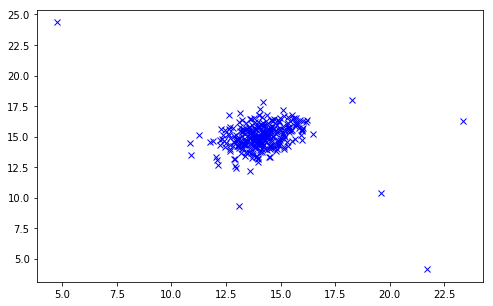

In [53]:
def plot_data():
    plt.figure(figsize=(8,5))
    plt.plot(X[:, 0], X[:, 1], 'bx')
  
plot_data()

## 1.1 Gaussian distribution
要执行异常检测，首先需要将模型拟合数据的分布。

多元高斯分布的p(x)为：
$$
    p(x) = \frac{1}{(2\pi)^{\frac{n}{2}}|Σ|^{\frac{1}{2}}}exp(-\frac{1}{2}(x-μ)^TΣ^{-1}(x-μ))
$$

In [60]:
def gaussian(X, mu, sigma2):
    n = len(mu)
    if np.ndim(sigma2) == 1:  # ndim表示矩阵的维数
        # array是一个1维数组时，结果形成一个以一维数组为对角线元素的矩阵
        # array是一个多维矩阵时，结果输出矩阵的对角线元素
        sigma2 = np.diag(sigma2)
        
    X = X - mu
    p1 = np.power(2 * np.pi, -n/2) * np.sqrt(np.linalg.det(sigma2))
         
    e = np.diag(X@np.linalg.inv(sigma2)@X.T)  # 取对角元素，类似与方差，而不要协方差
    p2 = np.exp(-.5*e)
    
    return p1 * p2

## 1.2 估计高斯分布的参数
你可以使用下面的方程估计第i个特征的参数$(μ_i,σ^2_i)$。估计平均值你可以使用：

$$
    μ_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}_i,
$$

估计方差可以使用：

$$
    σ^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)_i - μ_i})^2.
$$


In [55]:
def get_gaussian_params(X, use_multivariate):
    """
    The input X is the dataset with each n-dimensional data point in one row
    The output is an n-dimensional vector mu, the mean of the data set 
    the variances sigma^2, an n x 1 vector 或者是(n,n)矩阵，if你使用了多元高斯函数
    作业这里求样本方差除的是 m 而不是 m - 1，实际上效果差不了多少。
    """
    mu = X.mean(axis=0)
    
    if use_multivariate:
        sigma2 = ((X-mu).T @ (X- mu)) / len(X)
    else:
        sigma2 = X.var(axis=0, ddof=0)
        
    return mu, sigma2

In [58]:
def plot_contours(mu, sigma2):
    """
    画出高斯概率分布的图，在三维中是一个上凸的曲面。投影到平面上则是一圈圈的等高线。
    """
    delta = .3  # 注意delta不能太小！！！否则会生成太多的数据，导致矩阵相乘会出现内存错误。
    x = np.arange(0,30,delta)
    y = np.arange(0,30,delta)
    
    # 这部分要转化为X形式的坐标矩阵，也就是一列是横坐标，一列是纵坐标，
    # 然后才能传入gaussian中求解得到每个点的概率值
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()]  # 按列合并，一列横坐标，一列纵坐标
    z = gaussian(points, mu, sigma2)
    z = z.reshape(xx.shape)  # 这步骤不能忘
    
    cont_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx, yy, z, cont_levels)  # 这个levels是作业里面给的参考,或者通过求解的概率推出来。

    plt.title('Gaussian Contours',fontsize=16)

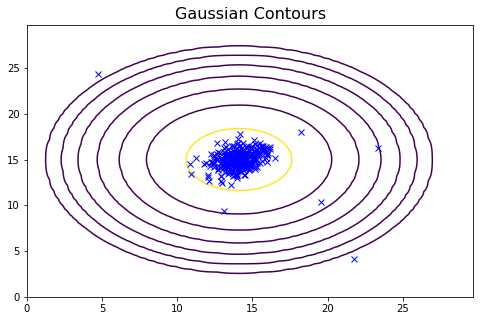

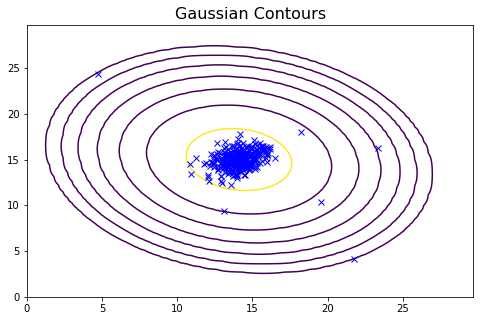

In [63]:
plot_data()
useMV = False
plot_contours(*get_gaussian_params(X, useMV))

# Then contours with multivariate gaussian:
plot_data()
useMV = True
# *表示解元组
plot_contours(*get_gaussian_params(X, useMV))